# Train `PINN`

In this example, [physics informed neural network (PINN)](https://maziarraissi.github.io/PINNs/) is used to train burgers equation.

#### Imports

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import optax
import serket as sk

#### Equation

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$


#### Data preparation

In [3]:
N_0 = 100  # number of points for initial condition
N_b = 100  # number of points for boundary condition
N_r = 10_000  # number of points for collocation

tmin, tmax = 0.0, 1.0
xmin, xmax = -1.0, 1.0

"""boundary conditions"""

keys = jax.random.split(jax.random.PRNGKey(0), 5)

# u[0,x] = -sin(pi*x)
t_0 = jnp.ones([N_0, 1], dtype="float32") * 0.0
x_0 = jr.uniform(key=keys[0], minval=xmin, maxval=xmax, shape=(N_0, 1))
ic_0 = -jnp.sin(jnp.pi * x_0)

# U[t,-1] = 0
t_b1 = jr.uniform(key=keys[1], minval=tmin, maxval=tmax, shape=(N_b, 1))
x_b1 = jnp.ones_like(t_b1) * -1
bc_1 = jnp.zeros_like(t_b1)

# U[t,1] = 0
t_b2 = jr.uniform(key=keys[1], minval=tmin, maxval=tmax, shape=(N_b, 1))
x_b2 = jnp.ones_like(t_b2)
bc_2 = jnp.zeros_like(t_b2)

# collocation points
t_c = jr.uniform(key=keys[2], minval=tmin, maxval=tmax, shape=(N_r, 1))
x_c = jr.uniform(key=keys[3], minval=xmin, maxval=xmax, shape=(N_r, 1))
z_c = jnp.zeros_like(t_c)

#### Data visualization

/var/folders/mv/cckpw89s2jjd622p9pywk0nm0000gn/T/ipykernel_81966/1429392938.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


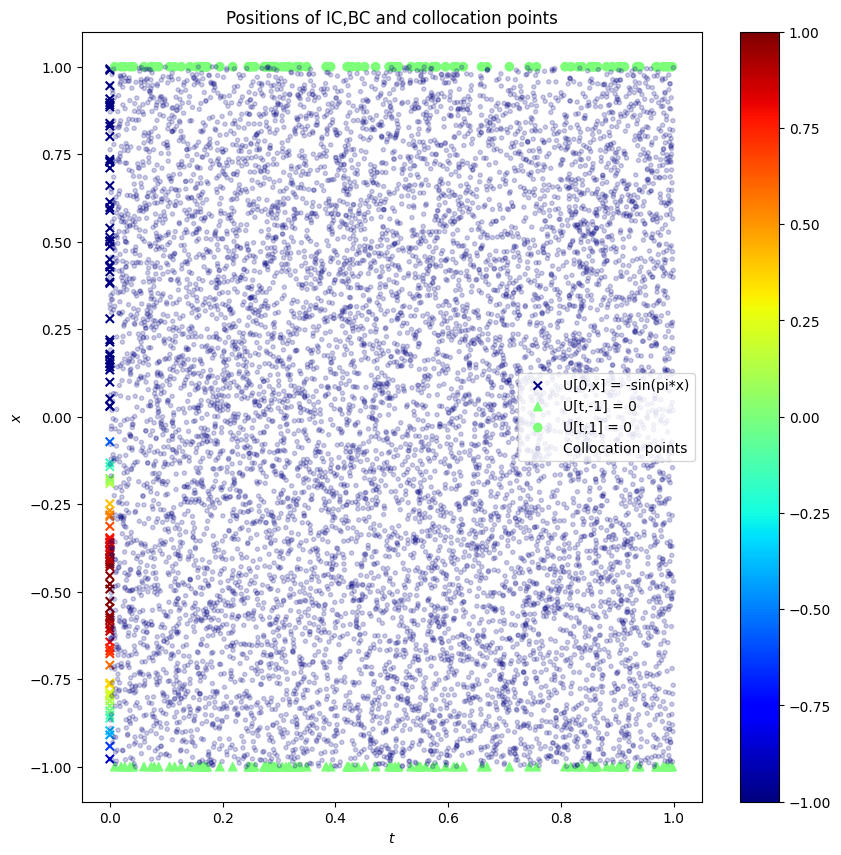

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    t_0,
    x_0,
    c=ic_0,
    marker="x",
    vmin=0,
    vmax=1,
    label="U[0,x] = -sin(pi*x)",
    cmap=cm.jet,
)
ax.scatter(
    t_b1,
    x_b1,
    c=bc_1,
    marker="^",
    vmin=-1,
    vmax=1,
    label="U[t,-1] = 0",
    cmap=cm.jet,
)
ax.scatter(
    t_b2,
    x_b2,
    c=bc_2,
    marker="o",
    vmin=-1,
    vmax=1,
    label="U[t,1] = 0",
    cmap=cm.jet,
)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-1, vmax=1)


ax.scatter(
    t_c,
    x_c,
    c=jnp.zeros_like(t_c),
    marker=".",
    alpha=0.2,
    label="Collocation points",
    cmap=cm.jet,
)


ax.set_xlabel("$t$")
ax.set_ylabel("$x$")

ax.set_title("Positions of IC,BC and collocation points")
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc="center right")

#### Define the neural network

In this step, we define a neural network $NN$ to satisfy the following equations


$$
\begin{aligned}
    \partial_t NN_u + NN_u \, \partial_x NN_u - (0.01/\pi) \, \partial_{xx} NN_u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   NN_u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   NN_u(t,-1) = NN_u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
class PINN(sk.TreeClass):
    def __init__(self, key: jr.KeyArray):
        keys = jr.split(key, 5)
        self.linear1 = sk.nn.Linear(2, 8, key=keys[0])
        self.linear2 = sk.nn.Linear(8, 8, key=keys[1])
        self.linear3 = sk.nn.Linear(8, 8, key=keys[2])
        self.linear4 = sk.nn.Linear(8, 8, key=keys[3])
        self.linear5 = sk.nn.Linear(8, 1, key=keys[4])

    def __call__(self, t: jax.Array, x: jax.Array) -> jax.Array:
        z = jnp.concatenate([t, x], axis=-1)
        z = jnp.tanh(self.linear1(z))
        z = jnp.tanh(self.linear2(z))
        z = jnp.tanh(self.linear3(z))
        z = jnp.tanh(self.linear4(z))
        z = self.linear5(z)
        return z

#### Define the loss function

In [6]:
def sum_func(func):
    return lambda *args: jnp.sum(func(*args))


def mse(x: jax.Array, y: jax.Array) -> jax.Array:
    assert x.shape == y.shape
    return jnp.mean((x - y) ** 2)


def loss_func(net: PINN) -> jax.Array:
    net = sk.tree_unmask(net)  # unmask the network parameters
    loss = mse(net(t_0, x_0), ic_0)  # initial condition loss
    loss += mse(net(t_b1, x_b1), bc_1)  # boundary condition loss
    loss += mse(net(t_b2, x_b2), bc_2)  # boundary condition loss

    # pde loss
    net_x = jax.grad(sum_func(net), 1)
    net_xx = jax.grad(sum_func(net_x), 1)
    net_t = jax.grad(sum_func(net), 0)

    lhs = net_t(t_c, x_c) + net(t_c, x_c) * net_x(t_c, x_c)
    rhs = (0.01 / jnp.pi) * net_xx(t_c, x_c)
    loss += mse(lhs, rhs)

    return loss

#### Define train step

In [7]:
pinn = PINN(key=jr.PRNGKey(0))

# mask the network parameters to use it across jax transformations
pinn = sk.tree_mask(pinn)

print(sk.tree_summary(pinn, depth=1))

lr = optax.piecewise_constant_schedule(
    init_value=1e-2,
    boundaries_and_scales={10_000: 0.1},
)
optim = optax.adam(lr)
optim_state = optim.init(pinn)


@jax.jit
def train_step(net: PINN, optim_state: optax.OptState):
    loss, grads = jax.value_and_grad(loss_func)(net)
    updates, optim_state = optim.update(grads, optim_state)
    net = optax.apply_updates(net, updates)
    return net, optim_state, loss


for i in range(1, 20_000 + 1):
    pinn, optim_state, loss = train_step(pinn, optim_state)
    if i % 500 == 0:
        print(f"Step {i:005d} loss {loss:.3e} lr {lr(i):.3e}")

# finally unmask the network parameters to use it
pinn = sk.tree_unmask(pinn)

┌────────┬──────┬─────┬───────┐
│Name    │Type  │Count│Size   │
├────────┼──────┼─────┼───────┤
│.linear1│Linear│24   │96.00B │
├────────┼──────┼─────┼───────┤
│.linear2│Linear│72   │288.00B│
├────────┼──────┼─────┼───────┤
│.linear3│Linear│72   │288.00B│
├────────┼──────┼─────┼───────┤
│.linear4│Linear│72   │288.00B│
├────────┼──────┼─────┼───────┤
│.linear5│Linear│9    │36.00B │
├────────┼──────┼─────┼───────┤
│Σ       │PINN  │249  │996.00B│
└────────┴──────┴─────┴───────┘
Step 00500 loss 1.093e-01 lr 1.000e-02
Step 01000 loss 6.875e-02 lr 1.000e-02
Step 01500 loss 4.410e-02 lr 1.000e-02
Step 02000 loss 5.203e-02 lr 1.000e-02
Step 02500 loss 6.511e-03 lr 1.000e-02
Step 03000 loss 5.114e-03 lr 1.000e-02
Step 03500 loss 4.435e-03 lr 1.000e-02
Step 04000 loss 4.016e-03 lr 1.000e-02
Step 04500 loss 3.603e-03 lr 1.000e-02
Step 05000 loss 7.565e-03 lr 1.000e-02
Step 05500 loss 3.148e-03 lr 1.000e-02
Step 06000 loss 2.852e-03 lr 1.000e-02
Step 06500 loss 8.434e-03 lr 1.000e-02
Step 07000 lo

#### Plot results

Text(0.5, 0.5, '$z$')

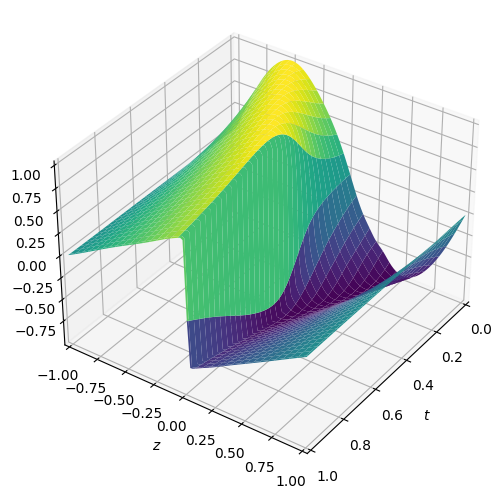

In [8]:
N = 100
tspace = jnp.linspace(tmin, tmax, N + 1)
xspace = jnp.linspace(xmin, xmax, N + 1)
T, X = jnp.meshgrid(tspace, xspace)
U = pinn(T.flatten().reshape(-1, 1), X.flatten().reshape(-1, 1)).reshape(N + 1, N + 1)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(T, X, U, cmap=cm.viridis)
ax.set_xlim(tmin, tmax)
ax.set_ylim(xmin, xmax)
ax.view_init(35, 35)
ax.set_xlabel("$t$")
ax.set_ylabel("$z$")